# Imports og congif

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler  # Normalization
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from minisom import MiniSom  # Self-Organizing Map
from mpl_toolkits.mplot3d import Axes3D
import skfuzzy as fuzz  # Fuzzy C-Means Clustering
from itertools import combinations
from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans
import numpy as np
from tabulate import tabulate

pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

N_CLUSTERS = 4

df = pd.read_csv(os.path.join('..', '..', 'data', 'Social-media', 'OnlineNewsPopularity.csv'))


# Clean; fjerne outliers


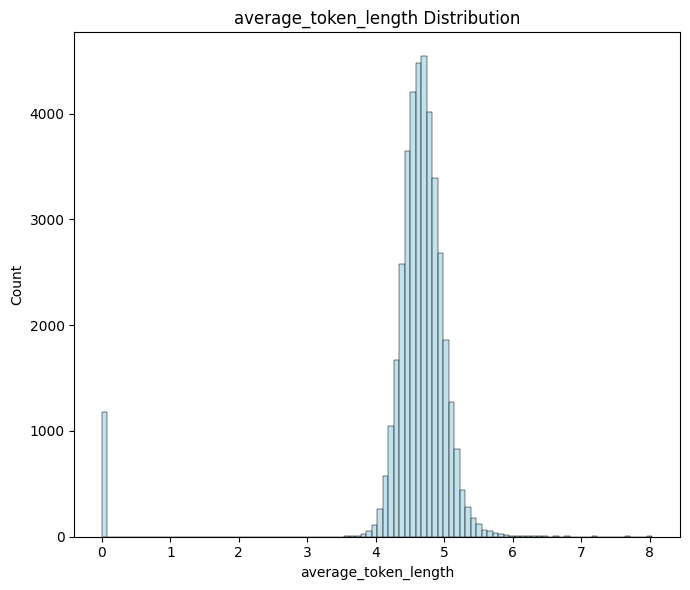

c:\IT3212\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 39644.
  res = hypotest_fun_out(*samples, **kwds)


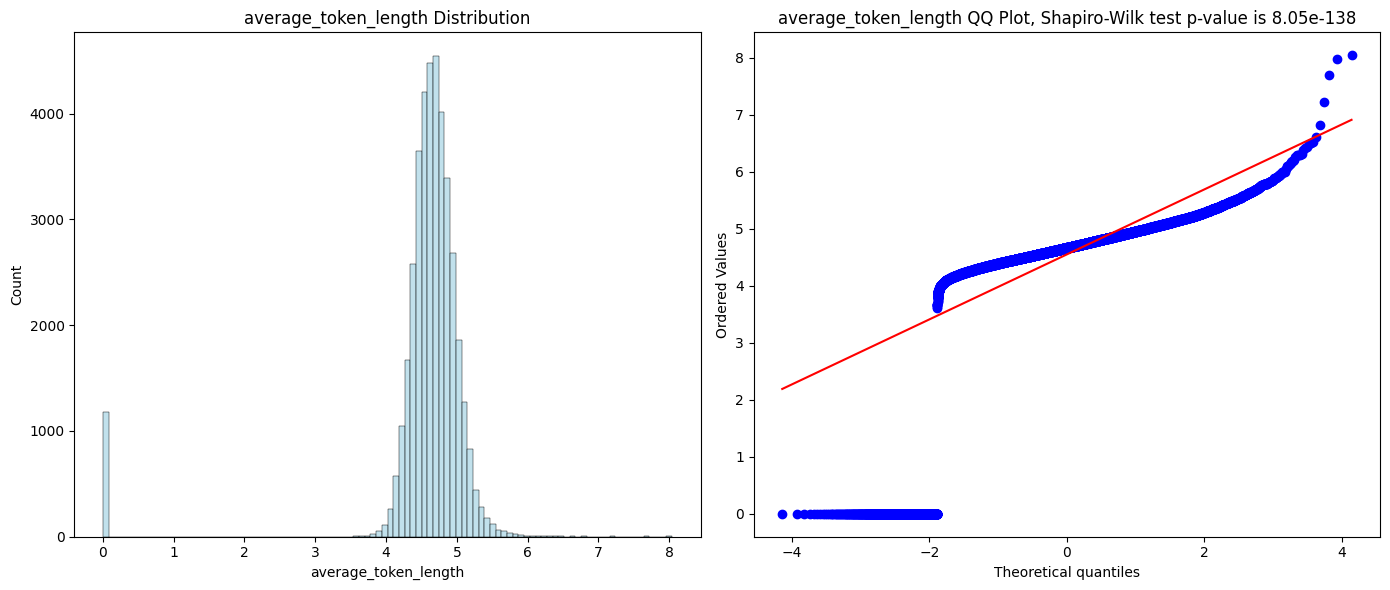

8.04711796066599e-138


C:\Users\ander\AppData\Local\Temp\ipykernel_7160\4134814662.py:110: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


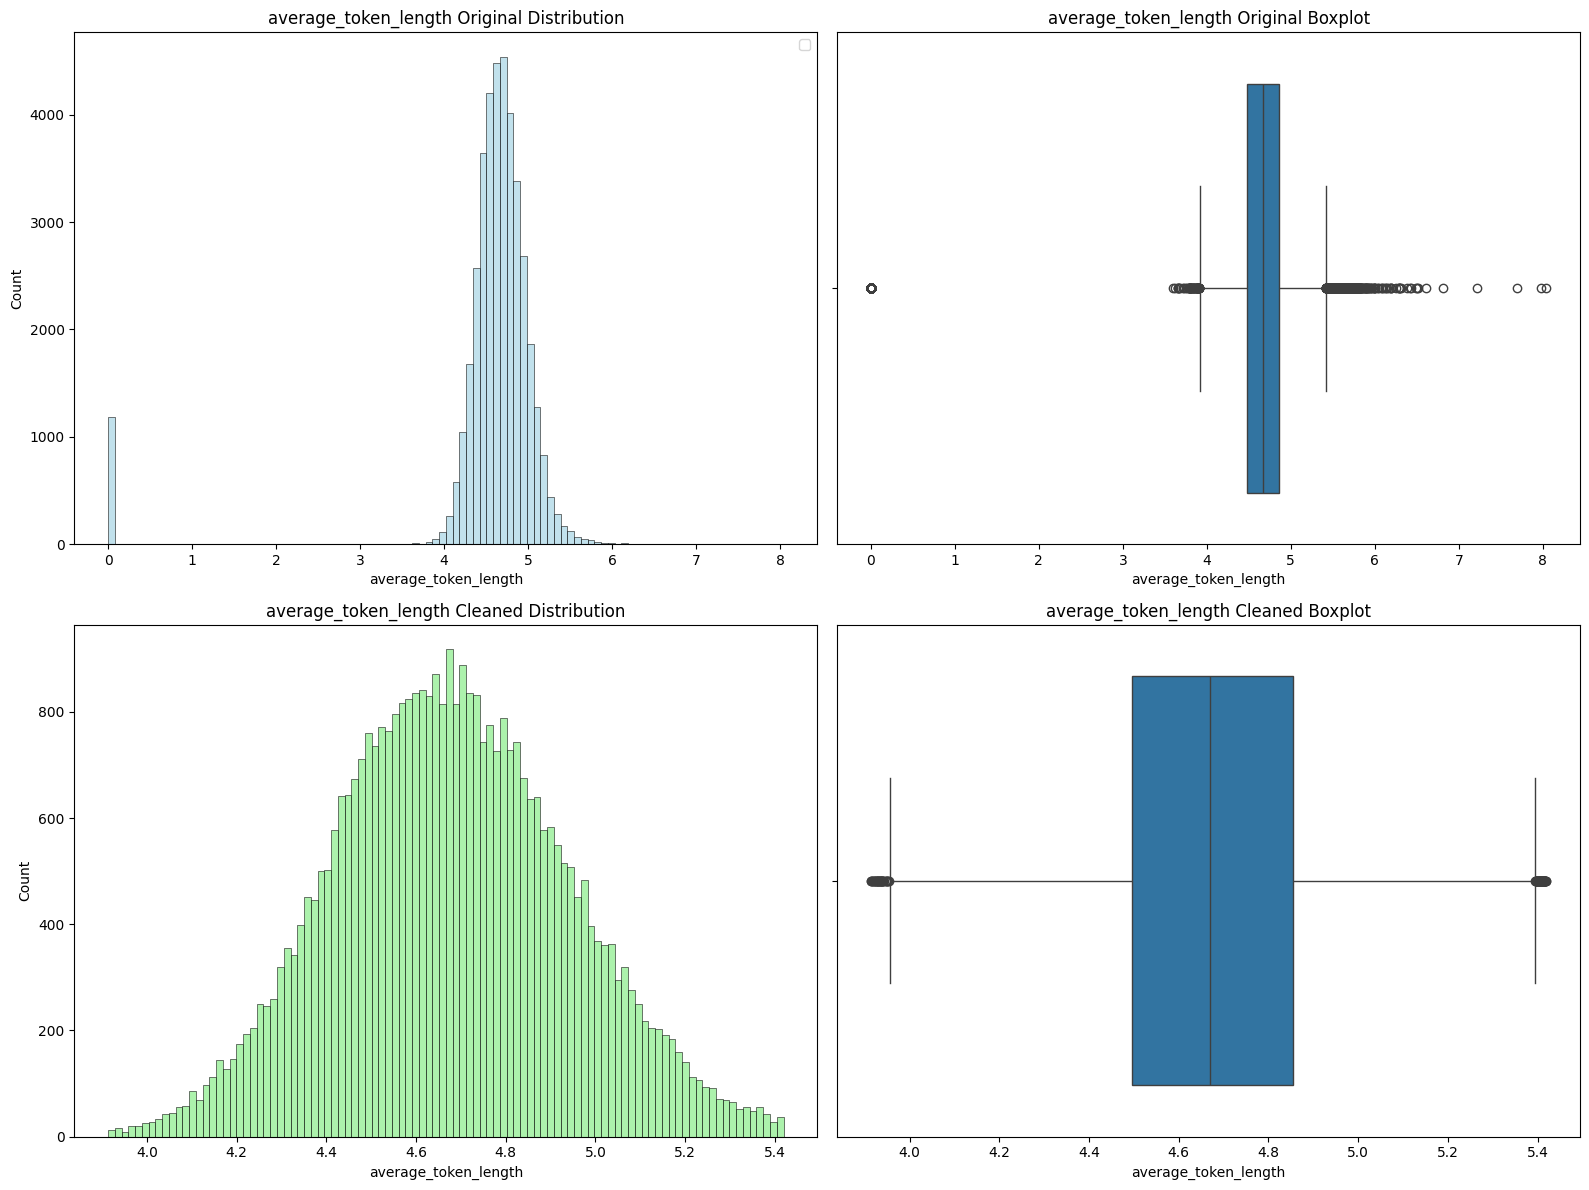

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

df = df.drop(columns=['url'], inplace=False)

# Function to check for normality using the Shapiro-Wilk test
def is_normal_distribution(data, alpha=0.05):
    stat, p_value = stats.shapiro(data)
    print(p_value)
    return p_value > 0.001  # If p-value > alpha, data is normal

# Function to plot distribution and QQ plot
def plot_distribution_qq(data, feature_name):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.histplot(data, kde=False, ax=axes[0], color='lightblue', bins=100)
    axes[0].set_title(f'{feature_name} Distribution')
    stat, p_value = stats.shapiro(data)
    stats.probplot(data, dist="norm", plot=axes[1])
    axes[1].set_title(f'{feature_name} QQ Plot, Shapiro-Wilk test p-value is {p_value:.2e}')

    plt.tight_layout()
    plt.show()

# Function for z-score outlier removal
def remove_outliers_z(data, threshold=3):
    z_scores = np.abs(stats.zscore(data))
    return data[z_scores < threshold]

# Function for IQR outlier removal
def remove_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return data[(data >= (Q1 - 1.5 * IQR)) & (data <= (Q3 + 1.5 * IQR))]

# List of features to skip
features_to_skip = [
    'data_channel_is_lifestyle',
    'data_channel_is_entertainment',
    'data_channel_is_bus',
    'data_channel_is_socmed',
    'data_channel_is_tech',
    'data_channel_is_world',
    'weekday_is_monday',
    'weekday_is_tuesday',
    'weekday_is_wednesday',
    'weekday_is_thursday',
    'weekday_is_friday',
    'weekday_is_saturday',
    'weekday_is_sunday',
    'is_weekend'
]

# Main loop through each feature
for feature in df.columns:
    if feature != 'average_token_length': continue

    # print(f'Processing {feature}')
    if feature == 'average_token_length':
        fig, ax = plt.subplots(1, 1, figsize=(7, 6))  # Create a single subplot
        sns.histplot(df[feature], kde=False, ax=ax, color='lightblue', bins=100)  # Use ax instead of axes[0]
        ax.set_title(f'{feature} Distribution')

        plt.tight_layout()
        plt.show()

        # Plot distribution and QQ plot
        plot_distribution_qq(df[feature], feature)

    # Check if the distribution is normal
    if is_normal_distribution(df[feature]):
        # print(f'{feature} is roughly normally distributed. Using z-score for outlier removal.')

        # Z-score method for outlier removal
        df[feature] = remove_outliers_z(df[feature])
        if feature != 'average_token_length': continue
        # Side-by-side plot: original distribution and cleaned distribution
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(df[feature], kde=False, color='lightblue', bins=100)
        outliers = df[feature][np.abs(stats.zscore(df[feature])) >= 3]
        plt.scatter(outliers.index, outliers, color='red', label='Outliers')
        plt.title(f'{feature} Original Distribution with Outliers Marked')
        plt.legend()

        plt.subplot(1, 2, 2)
        sns.histplot(df[feature], kde=True, color='lightgreen', bins=100)
        plt.title(f'{feature} Cleaned Distribution')

        plt.tight_layout()
        plt.show()

    else:
        # print(f'{feature} is not normally distributed. Using IQR for outlier removal.')

        # IQR method for outlier removal
        old = df[feature].copy()
        df[feature] = remove_outliers_iqr(df[feature])
        if feature != 'average_token_length': continue
        # Create a 2x2 grid of plots
        plt.figure(figsize=(16, 12))

        # Top row: Original distribution with outliers marked and boxplot
        plt.subplot(2, 2, 1)
        sns.histplot(old, kde=False, color='lightblue', bins=100)
        plt.title(f'{feature} Original Distribution')
        plt.legend()

        plt.subplot(2, 2, 2)
        sns.boxplot(x=old)
        plt.title(f'{feature} Original Boxplot')
      # Bottom row: Cleaned distribution and boxplot
        plt.subplot(2, 2, 3)
        sns.histplot(df[feature], kde=False, color='lightgreen', bins=100)
        plt.title(f'{feature} Cleaned Distribution')

        plt.subplot(2, 2, 4)
        sns.boxplot(x=df[feature])
        plt.title(f'{feature} Cleaned Boxplot')

        plt.tight_layout()
        plt.show()



# Transformation; scaling (normalization)

In [5]:
df = df.dropna()

# Select relevant numerical columns for clustering
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# Normalize the features
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df[numeric_cols])

# Feature extraction: PCA

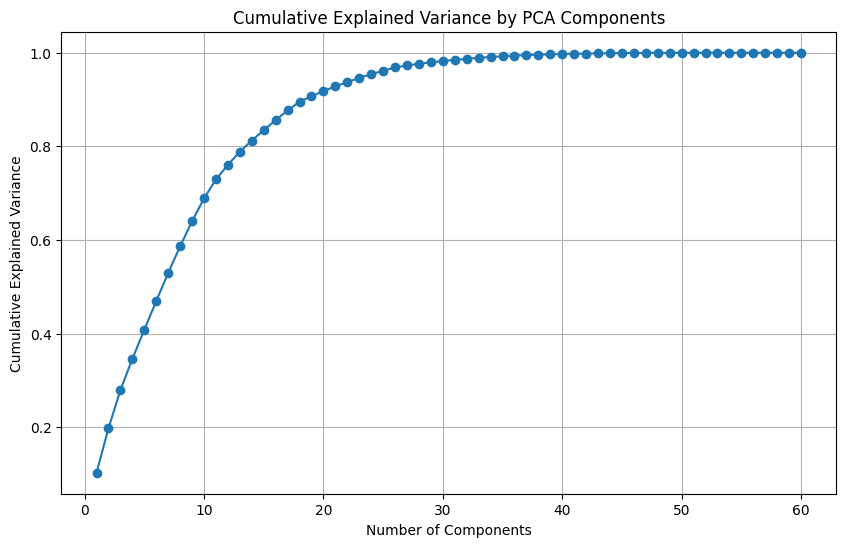

Selected 24 components to retain at least 95% of the variance.


In [6]:
# Step 3: Dimensionality Reduction (show cumulative variance before selecting components)
pca = PCA()
pca_fit = pca.fit(df_normalized)
explained_variance = np.cumsum(pca_fit.explained_variance_ratio_)

# Plot cumulative variance explained by PCA components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Select enough components to retain at least 95% variance
n_components = np.argmax(explained_variance >= 0.95) + 1  # Add 1 because of 0-based indexing
pca = PCA(n_components=n_components)
pca_fit = pca.fit(df_normalized)
reduced_data = pca.transform(df_normalized)

print(f'Selected {n_components} components to retain at least 95% of the variance.')

# Feature selection

Threshold score at 90.0% percentile: 0.16


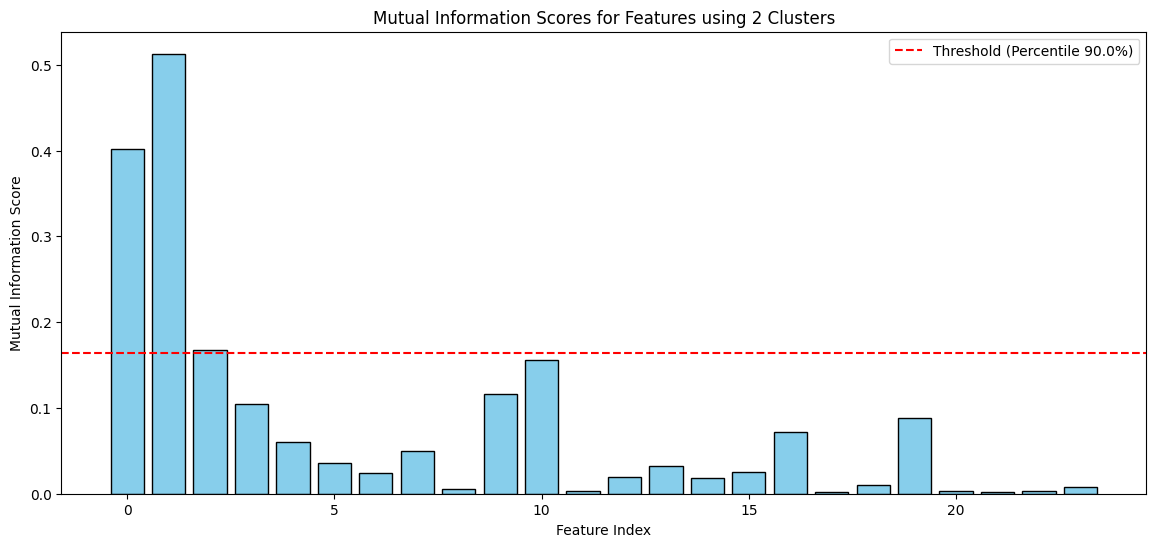

Threshold score at 90.0% percentile: 0.27


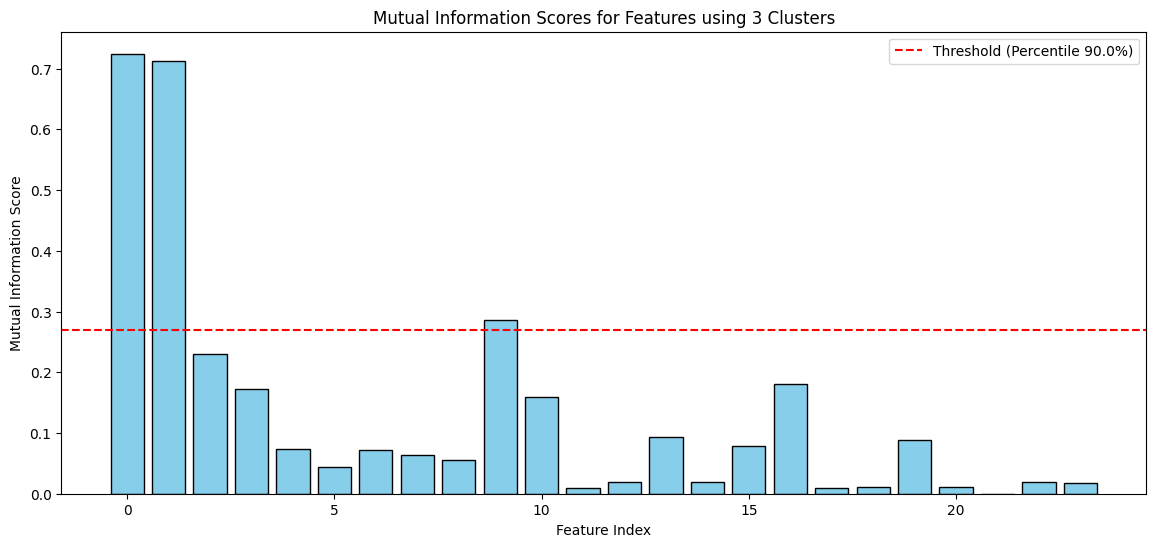

Threshold score at 90.0% percentile: 0.51


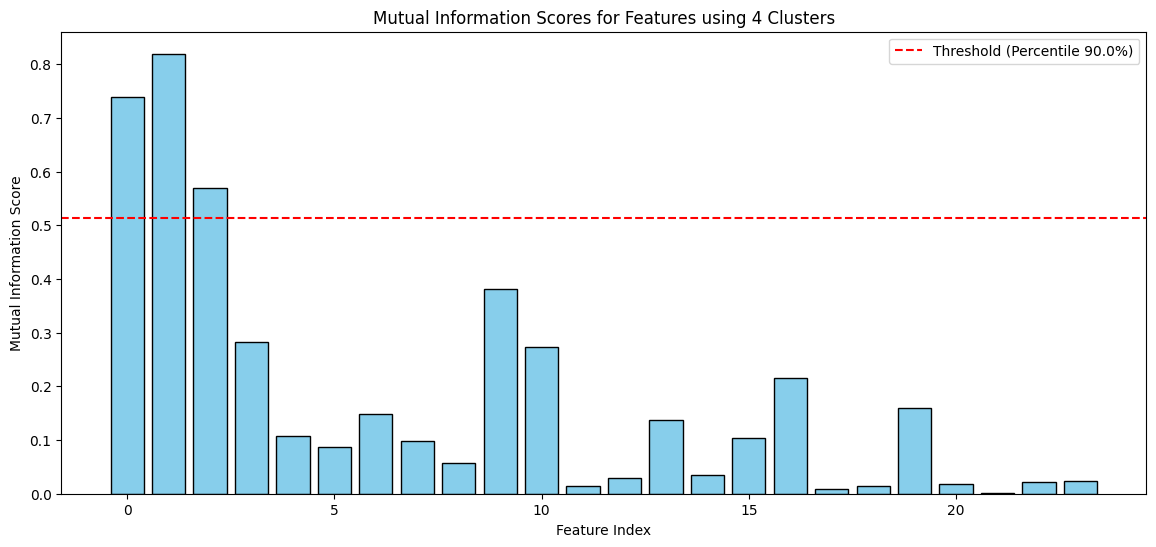

Threshold score at 90.0% percentile: 0.55


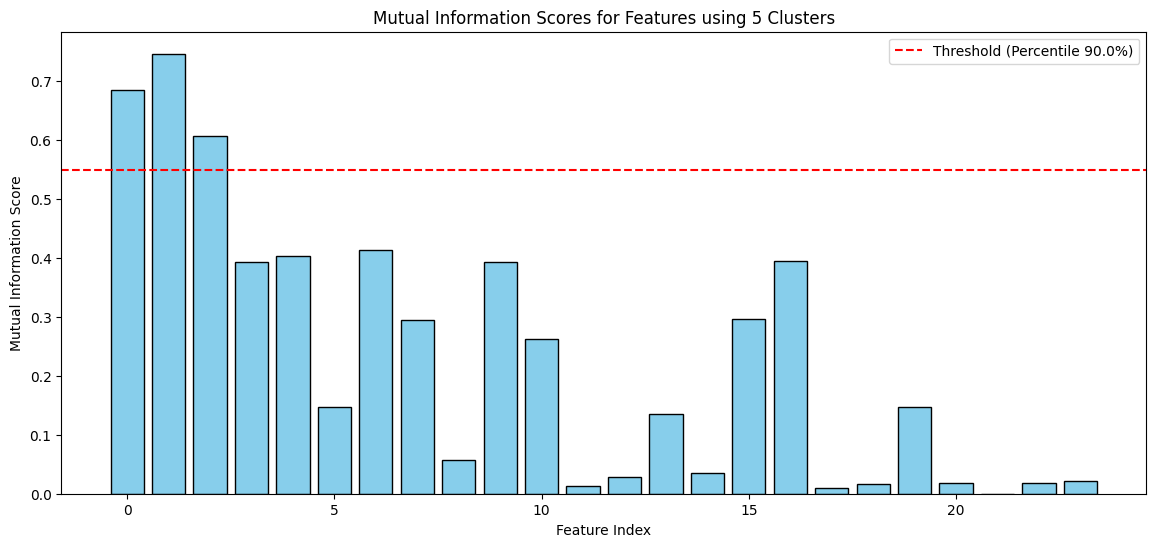

Threshold score at 90.0% percentile: 0.61


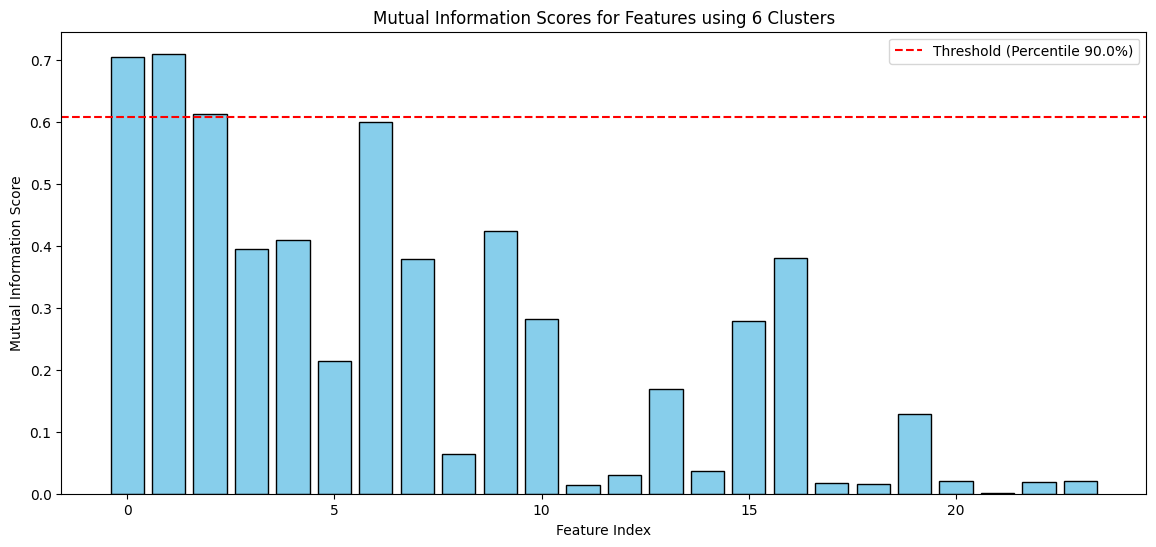

Threshold score at 90.0% percentile: 0.65


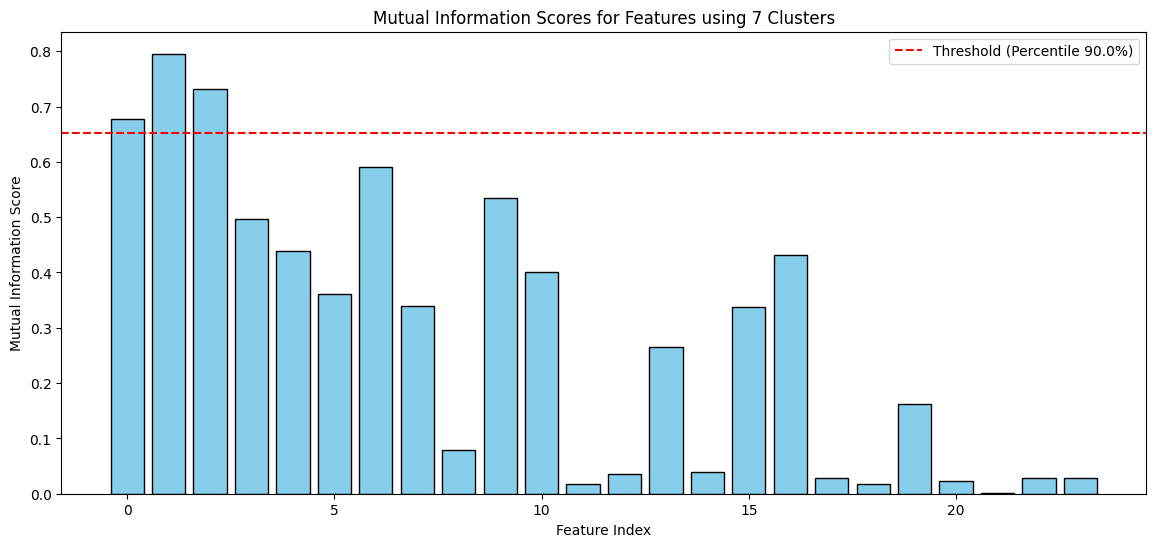

Threshold score at 90.0% percentile: 0.69


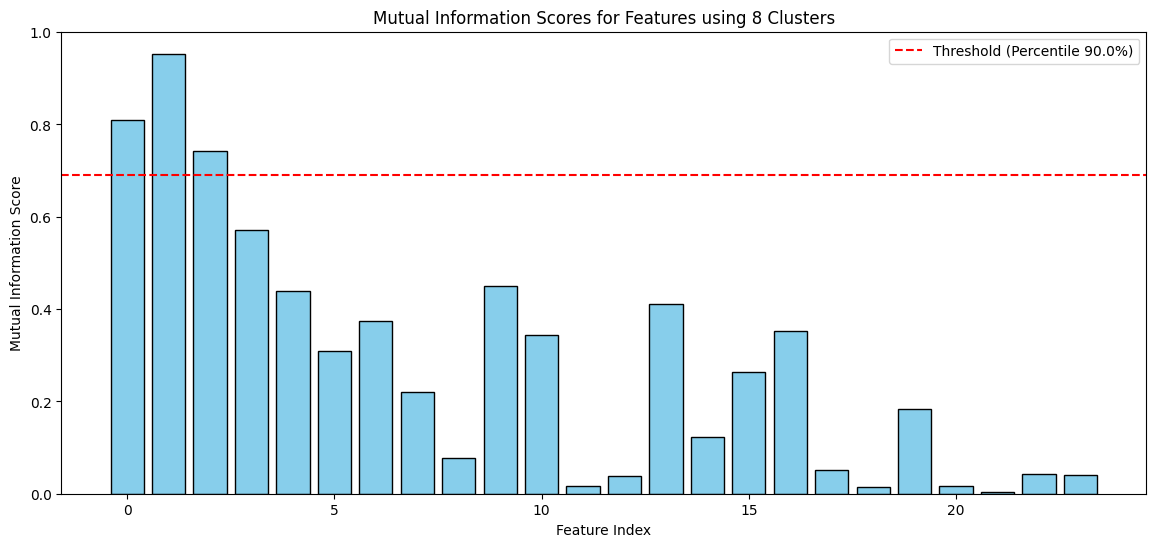

Threshold score at 90.0% percentile: 0.75


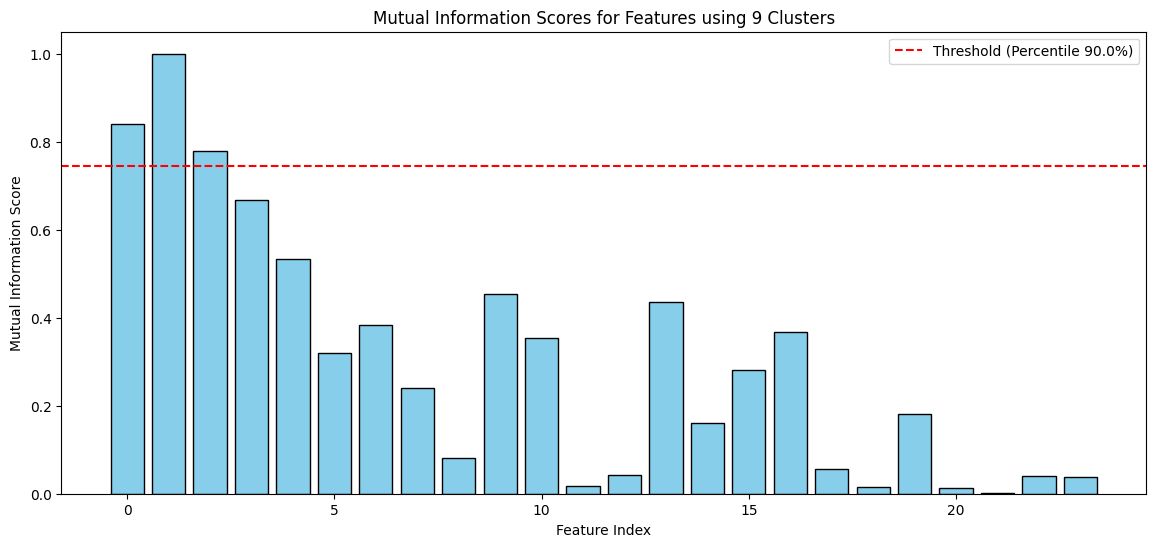

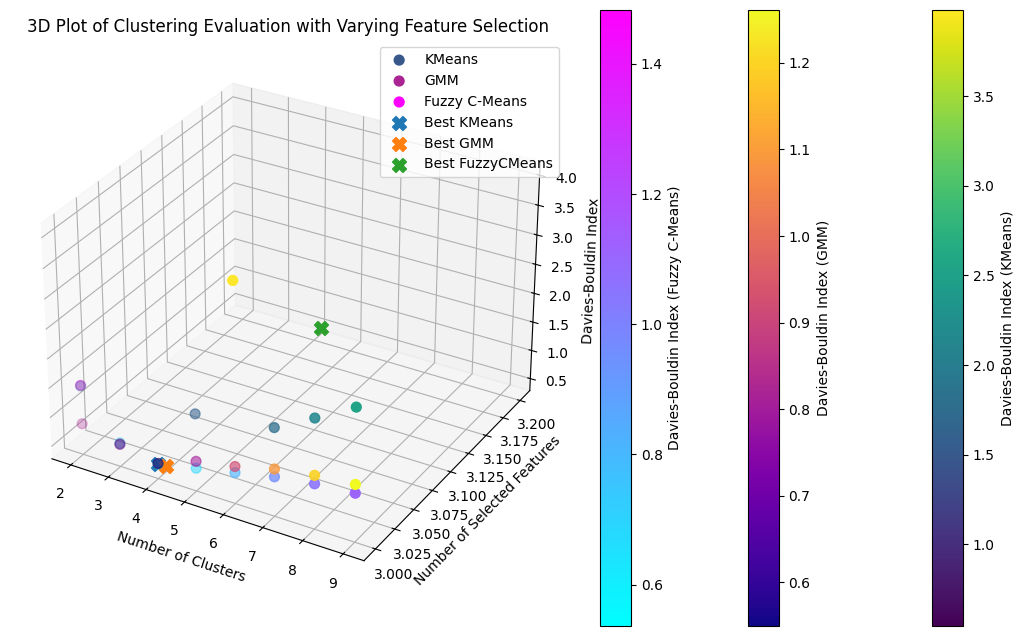

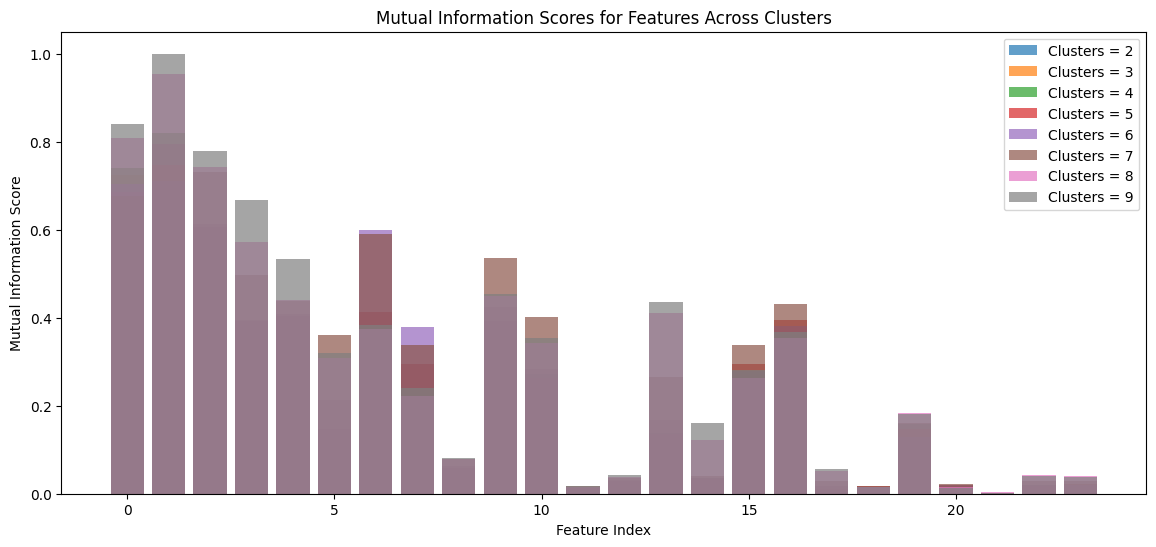

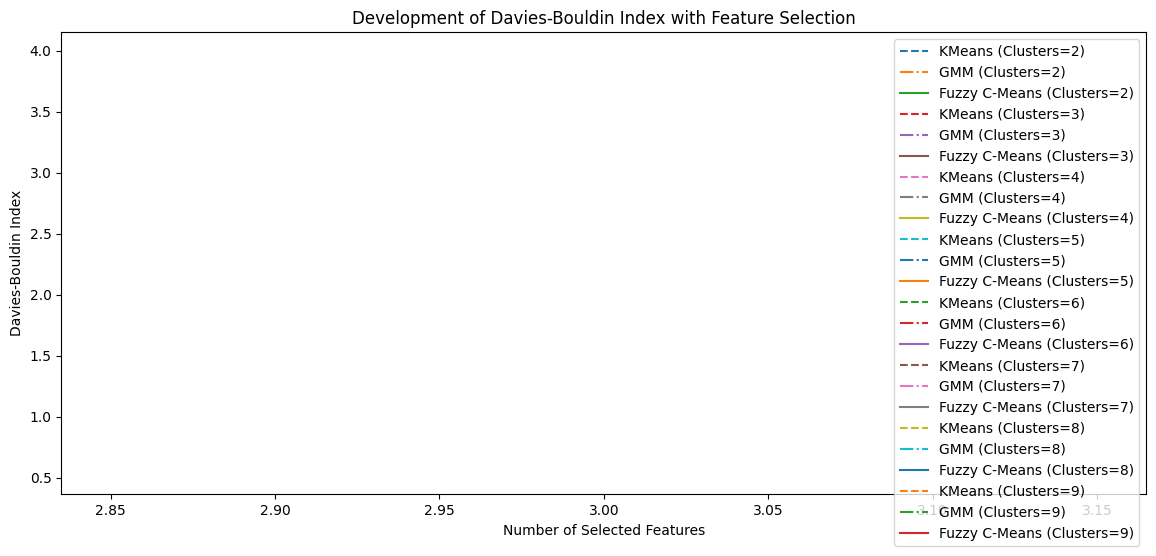

Best combination found for KMeans:
Number of Clusters: 4
Number of Selected Features: 3
Davies-Bouldin Index: 0.54
Selected Feature Indices: [0, 1, 2]
Best combination found for GMM:
Number of Clusters: 4
Number of Selected Features: 3
Davies-Bouldin Index: 0.54
Selected Feature Indices: [0, 1, 2]
Best combination found for FuzzyCMeans:
Number of Clusters: 4
Number of Selected Features: 3
Davies-Bouldin Index: 0.54
Selected Feature Indices: [0, 1, 2]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from sklearn.feature_selection import mutual_info_classif
from pyclustering.cluster.fcm import fcm

def filter_feature_selection(data, max_clusters=10, percentiles=[0.9]):
    db_scores = []
    all_mi_scores = []

    # Iterate over each number of clusters
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(data)

        # Calculate mutual information scores for all features
        mi_scores = mutual_info_classif(data, labels, discrete_features=False)

        threshold_score = np.percentile(mi_scores, 0.9 * 100)
        print(f"Threshold score at {0.9*100}% percentile: {threshold_score:.2f}")
        plt.figure(figsize=(14, 6))
        plt.bar(range(len(mi_scores)), mi_scores, color='skyblue', edgecolor='black')
        plt.axhline(y=threshold_score, color='red', linestyle='--', label=f'Threshold (Percentile {0.9*100}%)')
        plt.xlabel('Feature Index')
        plt.ylabel('Mutual Information Score')
        plt.title(f'Mutual Information Scores for Features using {n_clusters} Clusters')
        plt.legend()
        plt.show()

        all_mi_scores.append((n_clusters, mi_scores))

        # Iterate over different percentiles to select feature subsets
        for percentile in percentiles:
            threshold_score = np.percentile(mi_scores, percentile * 100)
            selected_features = [i for i, score in enumerate(mi_scores) if score >= threshold_score]

            if len(selected_features) > 0:
                data_selected = data[:, selected_features]

                # Evaluate DB score for KMeans
                db_index_kmeans = davies_bouldin_score(data_selected, labels)

                # Evaluate DB score for GMM
                gmm = GaussianMixture(n_components=n_clusters, random_state=42)
                gmm_labels = gmm.fit_predict(data_selected)
                db_index_gmm = davies_bouldin_score(data_selected, gmm_labels)

                # Evaluate DB score for FCM
                initial_centers = KMeans(n_clusters=n_clusters, random_state=42).fit(data_selected).cluster_centers_.tolist()
                fcm_instance = fcm(data_selected.tolist(), initial_centers)
                fcm_instance.process()
                fcm_labels = fcm_instance.get_clusters()

                fuzzy_labels = np.zeros(len(data_selected), dtype=int)
                for cluster_id, cluster_points in enumerate(fcm_labels):
                    for point_index in cluster_points:
                        fuzzy_labels[point_index] = cluster_id

                if len(set(fuzzy_labels)) > 1:
                    db_index_fcm = davies_bouldin_score(data_selected, fuzzy_labels)
                else:
                    db_index_fcm = np.nan

                # Store the scores
                db_scores.append((n_clusters, len(selected_features), db_index_kmeans, db_index_gmm, db_index_fcm, selected_features))

    # Find the best combination for each method
    best_combination = {
        'KMeans': min(db_scores, key=lambda x: x[2]),
        'GMM': min(db_scores, key=lambda x: x[3]),
        'FuzzyCMeans': min(db_scores, key=lambda x: x[4])
    }

    return db_scores, best_combination, all_mi_scores

# Run the feature selection and clustering evaluation
db_scores, best_combination, all_mi_scores = filter_feature_selection(reduced_data, max_clusters=9, percentiles=[0.9])

# Extract data for plotting
n_clusters_list, feature_counts, db_indices_kmeans, db_indices_gmm, db_indices_fcm, feature_subsets = zip(*db_scores)

# Plotting the 3D plot with highlighted best combination
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of DB scores for each method
sc_kmeans = ax.scatter(n_clusters_list, feature_counts, db_indices_kmeans, c=db_indices_kmeans, cmap='viridis', s=50, label='KMeans')
sc_gmm = ax.scatter(n_clusters_list, feature_counts, db_indices_gmm, c=db_indices_gmm, cmap='plasma', s=50, label='GMM')
sc_fcm = ax.scatter(n_clusters_list, feature_counts, db_indices_fcm, c=db_indices_fcm, cmap='cool', s=50, label='Fuzzy C-Means')

# Highlight the best combinations with an offset to avoid overlap
offset = 0.2
for i, (method, best_comb) in enumerate(best_combination.items()):
    ax.scatter(
        best_comb[0] + (offset if i > 0 else 0),
        best_comb[1] + (offset if i > 1 else 0),
        best_comb[2],
        label=f'Best {method}',
        s=100,
        marker='X'
    )

ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Number of Selected Features')
ax.set_zlabel('Davies-Bouldin Index')
ax.set_title('3D Plot of Clustering Evaluation with Varying Feature Selection')
plt.colorbar(sc_kmeans, label='Davies-Bouldin Index (KMeans)')
plt.colorbar(sc_gmm, label='Davies-Bouldin Index (GMM)')
plt.colorbar(sc_fcm, label='Davies-Bouldin Index (Fuzzy C-Means)')
ax.legend()

plt.show()

# Plotting the Mutual Information (MI) scores as a bar chart
fig, ax = plt.subplots(figsize=(14, 6))
for n_clusters, mi_scores in all_mi_scores:
    ax.bar(range(len(mi_scores)), mi_scores, label=f'Clusters = {n_clusters}', alpha=0.7)

ax.set_xlabel('Feature Index')
ax.set_ylabel('Mutual Information Score')
ax.set_title('Mutual Information Scores for Features Across Clusters')
ax.legend()

plt.show()

# Plotting the development of the DB index as a function of the number of clusters and feature selection
fig, ax = plt.subplots(figsize=(14, 6))
db_indices_per_cluster = {}

for n_clusters, feature_count, db_index_kmeans, db_index_gmm, db_index_fcm, _ in db_scores:
    if n_clusters not in db_indices_per_cluster:
        db_indices_per_cluster[n_clusters] = []
    db_indices_per_cluster[n_clusters].append((feature_count, db_index_kmeans, db_index_gmm, db_index_fcm))

# Plot DB index as a function of number of features for each clustering method
for n_clusters, values in db_indices_per_cluster.items():
    feature_counts, db_indices_kmeans, db_indices_gmm, db_indices_fcm = zip(*values)
    ax.plot(feature_counts, db_indices_kmeans, label=f'KMeans (Clusters={n_clusters})', linestyle='--')
    ax.plot(feature_counts, db_indices_gmm, label=f'GMM (Clusters={n_clusters})', linestyle='-.')
    ax.plot(feature_counts, db_indices_fcm, label=f'Fuzzy C-Means (Clusters={n_clusters})', linestyle='-')

ax.set_xlabel('Number of Selected Features')
ax.set_ylabel('Davies-Bouldin Index')
ax.set_title('Development of Davies-Bouldin Index with Feature Selection')
ax.legend()

plt.show()

# Print out the best combinations for each method
for method, best_comb in best_combination.items():
    print(f"Best combination found for {method}:")
    print(f"Number of Clusters: {best_comb[0]}")
    print(f"Number of Selected Features: {best_comb[1]}")
    print(f"Davies-Bouldin Index: {best_comb[2]:.2f}")
    print(f"Selected Feature Indices: {best_comb[5]}")





In [8]:
def filter_feature_selection(data, n_clusters, percentile=0.75):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    mi_scores = mutual_info_classif(data, labels, discrete_features=False)
    threshold_score = np.percentile(mi_scores, percentile * 100)
    return [i for i, score in enumerate(mi_scores) if score >= threshold_score]

n_clusters = N_CLUSTERS
percentile = 0.9
selected_features = filter_feature_selection(reduced_data, n_clusters, percentile=percentile)
print(f"Selected feature indices: {selected_features}")
print(f"Number of selected features: {len(selected_features)}")
reduced_data_selected = reduced_data[:, selected_features]

Selected feature indices: [0, 1, 2]
Number of selected features: 3


# Compare

       Algorithm  Execution Time (s)  Davies-Bouldin Index  Silhouette Score
0         KMeans                0.02                  0.54              0.62
1            GMM                0.14                  0.55              0.61
2  Fuzzy C-Means                0.75                  0.54              0.62


C:\Users\ander\AppData\Local\Temp\ipykernel_7160\1900346230.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Algorithm', y='Execution Time (s)', data=results_df, palette=palette, ax=axes[0])
C:\Users\ander\AppData\Local\Temp\ipykernel_7160\1900346230.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Algorithm', y='Davies-Bouldin Index', data=results_df, palette=palette, ax=axes[1])
C:\Users\ander\AppData\Local\Temp\ipykernel_7160\1900346230.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Algorithm', y='Silhouette Score',

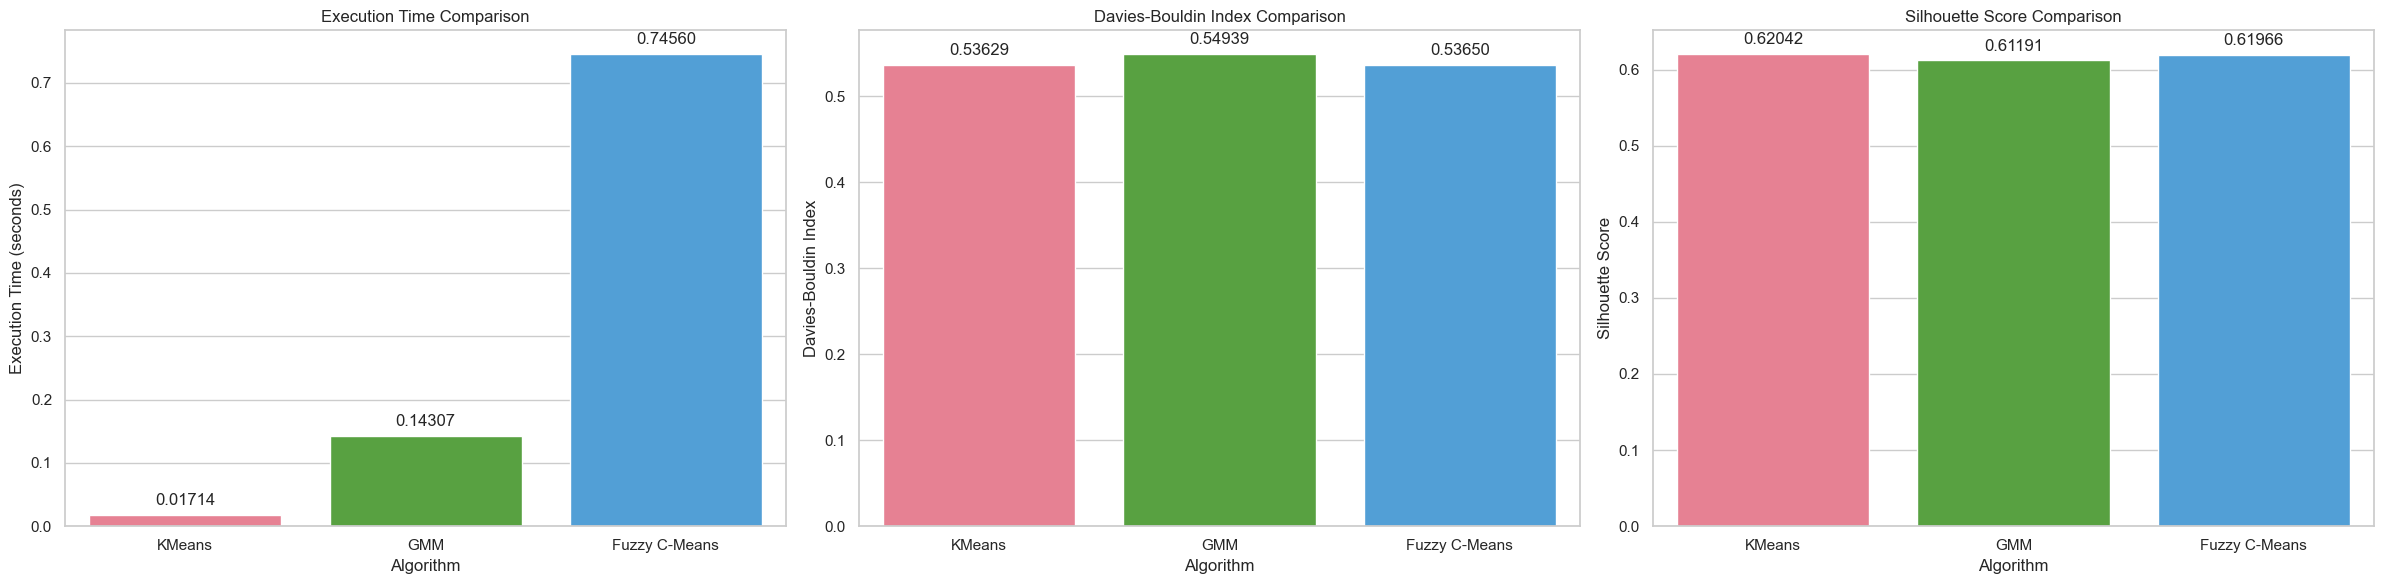

C:\Users\ander\AppData\Local\Temp\ipykernel_7160\1900346230.py:94: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  markerfacecolor=plt.cm.get_cmap(cmap)(j / (n_clusters - 1)), markersize=10)


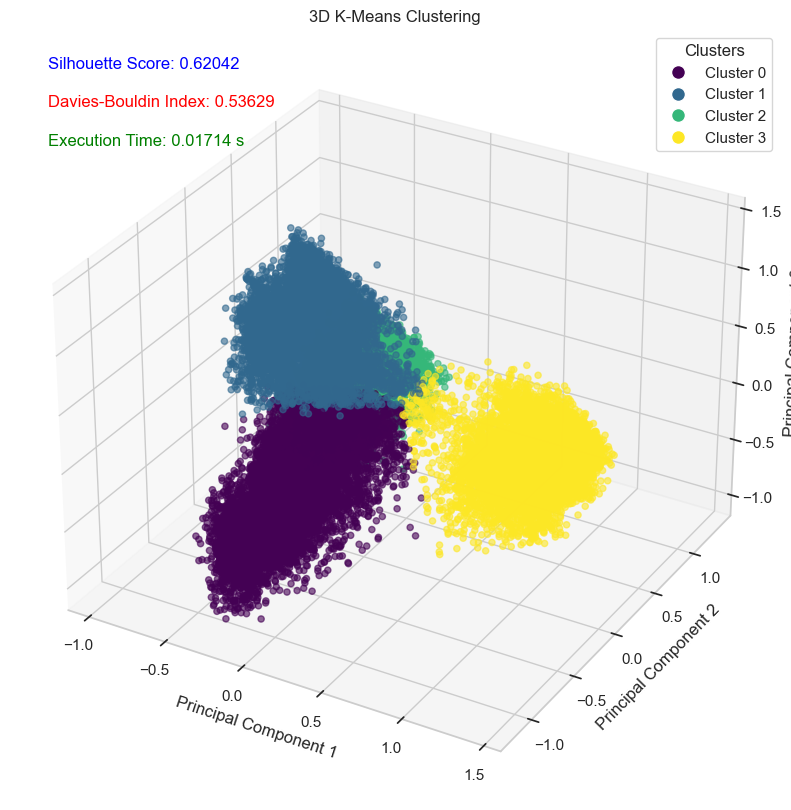

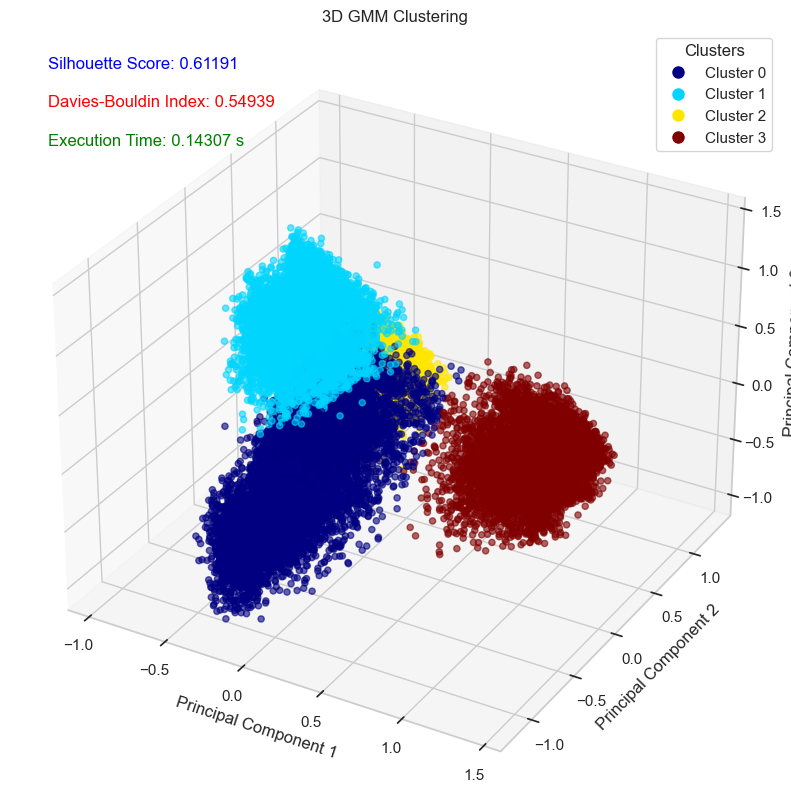

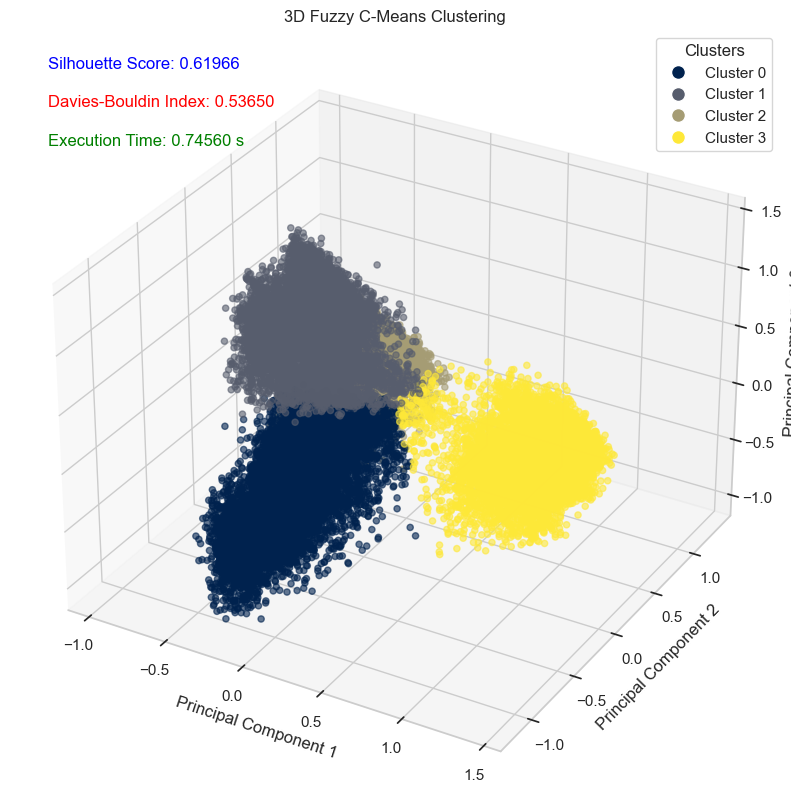

In [25]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, silhouette_score
from pyclustering.cluster.fcm import fcm
from matplotlib.lines import Line2D

# Function to evaluate and measure runtime
def evaluate_algorithm(algorithm, data, algorithm_name, n_clusters):
    start_time = time.time()
    if algorithm_name in ['KMeans', 'GMM']:
        labels = algorithm.fit_predict(data)
    elif algorithm_name == 'Fuzzy C-Means':
        data_list = data.tolist()
        initial_centers = KMeans(n_clusters=n_clusters, random_state=42).fit(data).cluster_centers_.tolist()
        fcm_instance = fcm(data_list, initial_centers)
        fcm_instance.process()
        labels = np.zeros(len(data), dtype=int)
        for cluster_id, cluster_points in enumerate(fcm_instance.get_clusters()):
            for point_index in cluster_points:
                labels[point_index] = cluster_id

    execution_time = time.time() - start_time
    davies_bouldin = davies_bouldin_score(data, labels)
    silhouette = silhouette_score(data, labels) if len(set(labels)) > 1 else -1
    return labels, execution_time, davies_bouldin, silhouette

# Plotting helper functions
def plot_bar_comparison(data, x, y, title, ylabel, palette, fmt="{:.5f}"):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=x, y=y, data=data, palette=palette)
    plt.title(title)
    plt.xlabel('Algorithm')
    plt.ylabel(ylabel)
    for rect in ax.patches:
        height = rect.get_height()
        ax.annotate(fmt.format(height), xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
    plt.show()

def plot_side_by_side_bar_comparisons(results_df):
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    palette = sns.color_palette("husl", n_colors=len(results_df['Algorithm'].unique()))

    # Plot Execution Time
    sns.barplot(x='Algorithm', y='Execution Time (s)', data=results_df, palette=palette, ax=axes[0])
    axes[0].set_title('Execution Time Comparison')
    axes[0].set_ylabel('Execution Time (seconds)')
    for rect in axes[0].patches:
        height = rect.get_height()
        axes[0].annotate(f"{height:.5f}", xy=(rect.get_x() + rect.get_width() / 2, height),
                         xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')

    # Plot Davies-Bouldin Index
    sns.barplot(x='Algorithm', y='Davies-Bouldin Index', data=results_df, palette=palette, ax=axes[1])
    axes[1].set_title('Davies-Bouldin Index Comparison')
    axes[1].set_ylabel('Davies-Bouldin Index')
    for rect in axes[1].patches:
        height = rect.get_height()
        axes[1].annotate(f"{height:.5f}", xy=(rect.get_x() + rect.get_width() / 2, height),
                         xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')

    # Plot Silhouette Score
    sns.barplot(x='Algorithm', y='Silhouette Score', data=results_df, palette=palette, ax=axes[2])
    axes[2].set_title('Silhouette Score Comparison')
    axes[2].set_ylabel('Silhouette Score')
    for rect in axes[2].patches:
        height = rect.get_height()
        axes[2].annotate(f"{height:.5f}", xy=(rect.get_x() + rect.get_width() / 2, height),
                         xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

def plot_clusters_3d(data, labels, title, cmap, silhouette_score, dbi_score, execution_time, n_clusters):
    """
    Plot a 3D clustering result and show silhouette and DBI scores.
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap=cmap, alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')

    # Add cluster legends
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f'Cluster {j}',
               markerfacecolor=plt.cm.get_cmap(cmap)(j / (n_clusters - 1)), markersize=10)
        for j in range(n_clusters)
    ]
    ax.legend(handles=legend_elements, title='Clusters', loc='upper right')

    # Add silhouette and Davies-Bouldin Index scores as text
    ax.text2D(0.05, 0.90, f'Davies-Bouldin Index: {dbi_score:.5f}', transform=ax.transAxes, fontsize=12, color='red')
    ax.text2D(0.05, 0.95, f'Silhouette Score: {silhouette_score:.5f}', transform=ax.transAxes, fontsize=12, color='blue')
    ax.text2D(0.05, 0.85, f'Execution Time: {execution_time:.5f} s', transform=ax.transAxes, fontsize=12, color='green')
    
    plt.show()

# Parameters and data preparation
N_CLUSTERS = 4
# Ensure `reduced_data_selected` contains your preprocessed data (e.g., PCA components)

# Initialize and evaluate algorithms
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
gmm = GaussianMixture(n_components=N_CLUSTERS, random_state=42)

kmeans_labels, kmeans_time, kmeans_dbi, kmeans_silhouette = evaluate_algorithm(kmeans, reduced_data_selected[:, :3], 'KMeans', N_CLUSTERS)
gmm_labels, gmm_time, gmm_dbi, gmm_silhouette = evaluate_algorithm(gmm, reduced_data_selected[:, :3], 'GMM', N_CLUSTERS)
fuzzy_labels, fuzzy_time, fuzzy_dbi, fuzzy_silhouette = evaluate_algorithm(None, reduced_data_selected[:, :3], 'Fuzzy C-Means', N_CLUSTERS)

# Create results dataframe
results_df = pd.DataFrame({
    'Algorithm': ['KMeans', 'GMM', 'Fuzzy C-Means'],
    'Execution Time (s)': [kmeans_time, gmm_time, fuzzy_time],
    'Davies-Bouldin Index': [kmeans_dbi, gmm_dbi, fuzzy_dbi],
    'Silhouette Score': [kmeans_silhouette, gmm_silhouette, fuzzy_silhouette]
})

# Display results
print(results_df)

# Plot all comparisons side by side
plot_side_by_side_bar_comparisons(results_df)

# Plot each clustering result in a separate 3D plot with silhouette, DBI scores, and runtime
plot_clusters_3d(
    reduced_data_selected[:, :3],
    kmeans_labels,
    '3D K-Means Clustering',
    'viridis',
    kmeans_silhouette,
    kmeans_dbi,
    kmeans_time,
    N_CLUSTERS
)

plot_clusters_3d(
    reduced_data_selected[:, :3],
    gmm_labels,
    '3D GMM Clustering',
    'jet',
    gmm_silhouette,
    gmm_dbi,
    gmm_time,
    N_CLUSTERS
)

plot_clusters_3d(
    reduced_data_selected[:, :3],
    fuzzy_labels,
    '3D Fuzzy C-Means Clustering',
    'cividis',
    fuzzy_silhouette,
    fuzzy_dbi,
    fuzzy_time,
    N_CLUSTERS
)


In [26]:
results_df = pd.DataFrame({
    'Algorithm': ['KMeans', 'GMM', 'Fuzzy C-Means'],
    'Execution Time (s)': [kmeans_time, gmm_time, fuzzy_time],
    'Big O Runtime': ['O(n * k * I)', 'O(n * k^2)', 'O(n * k^2 * I)'],  # Example big O notations
    'Davies-Bouldin Index': [kmeans_dbi, gmm_dbi, fuzzy_dbi],
    'Silhouette Score': [kmeans_silhouette, gmm_silhouette, fuzzy_silhouette]
})

# Generate a LaTeX table from the DataFrame
latex_table = results_df.to_latex(index=False, float_format="%.5f", escape=False)

# Print the LaTeX table to use in a LaTeX document
print(latex_table)

\begin{tabular}{lrlrr}
\toprule
Algorithm & Execution Time (s) & Big O Runtime & Davies-Bouldin Index & Silhouette Score \\
\midrule
KMeans & 0.01714 & O(n * k * I) & 0.53629 & 0.62042 \\
GMM & 0.14307 & O(n * k^2) & 0.54939 & 0.61191 \\
Fuzzy C-Means & 0.74560 & O(n * k^2 * I) & 0.53650 & 0.61966 \\
\bottomrule
\end{tabular}



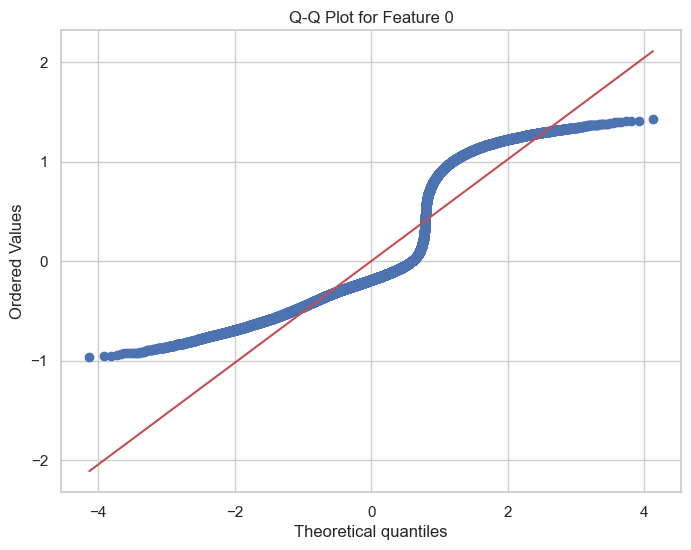

Shapiro-Wilk Test for Feature 0:
Statistic = 0.8283, p-value = 0.0000
The data for Feature 0 does not appear to be normally distributed (p <= 0.05).


c:\IT3212\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 37963.
  res = hypotest_fun_out(*samples, **kwds)


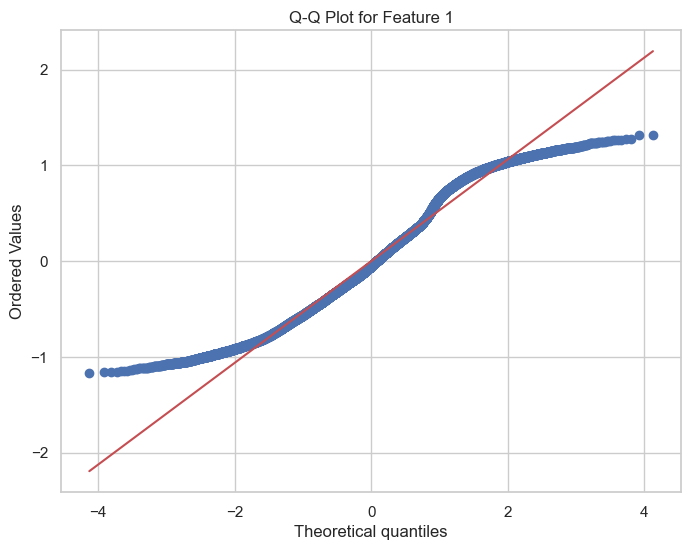

Shapiro-Wilk Test for Feature 1:
Statistic = 0.9765, p-value = 0.0000
The data for Feature 1 does not appear to be normally distributed (p <= 0.05).


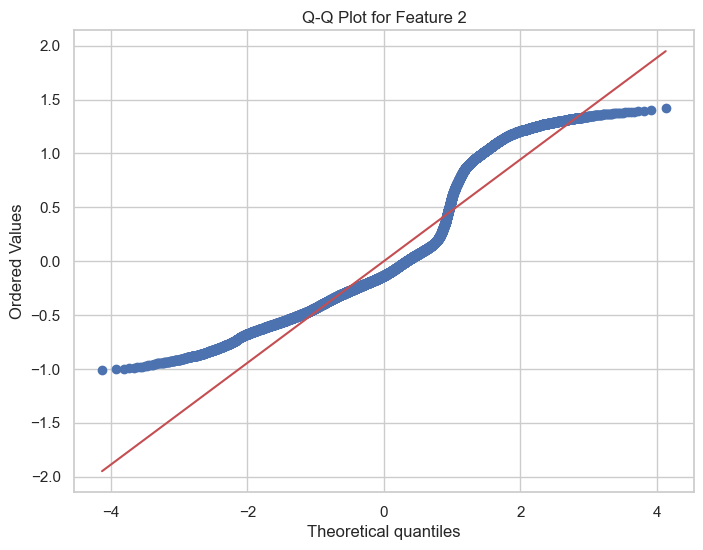

Shapiro-Wilk Test for Feature 2:
Statistic = 0.8906, p-value = 0.0000
The data for Feature 2 does not appear to be normally distributed (p <= 0.05).


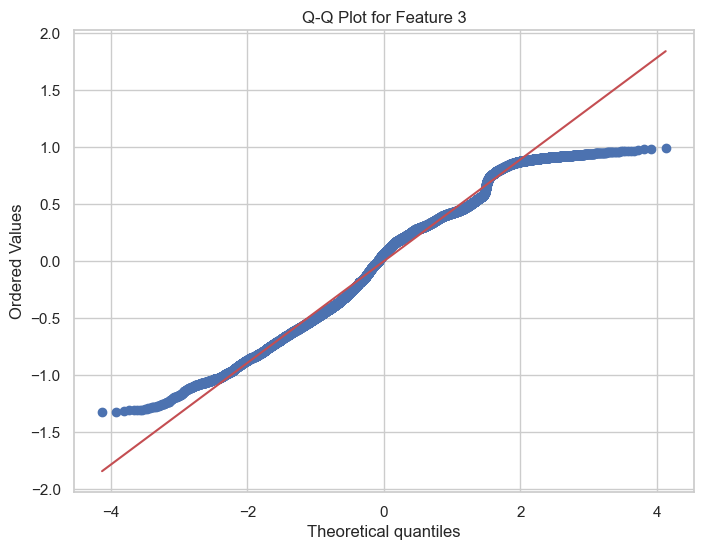

Shapiro-Wilk Test for Feature 3:
Statistic = 0.9816, p-value = 0.0000
The data for Feature 3 does not appear to be normally distributed (p <= 0.05).


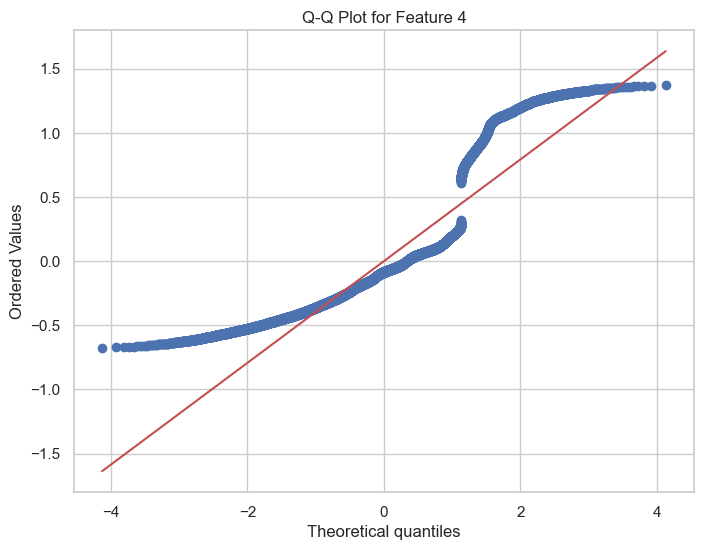

Shapiro-Wilk Test for Feature 4:
Statistic = 0.8251, p-value = 0.0000
The data for Feature 4 does not appear to be normally distributed (p <= 0.05).


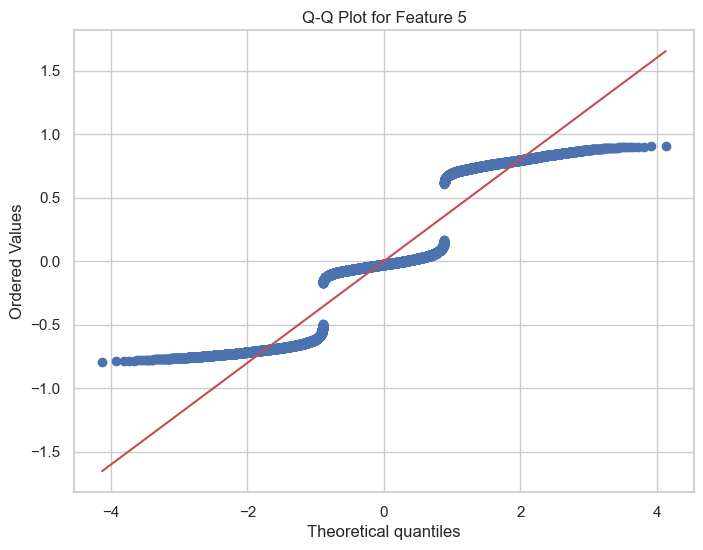

Shapiro-Wilk Test for Feature 5:
Statistic = 0.8554, p-value = 0.0000
The data for Feature 5 does not appear to be normally distributed (p <= 0.05).


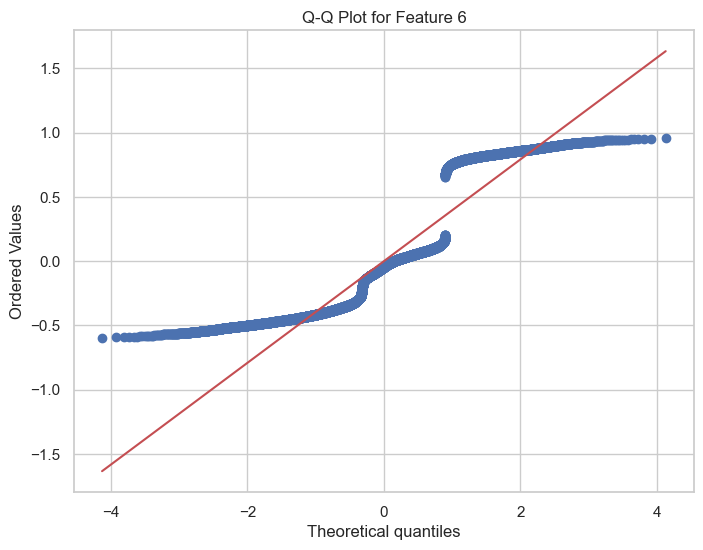

Shapiro-Wilk Test for Feature 6:
Statistic = 0.8472, p-value = 0.0000
The data for Feature 6 does not appear to be normally distributed (p <= 0.05).


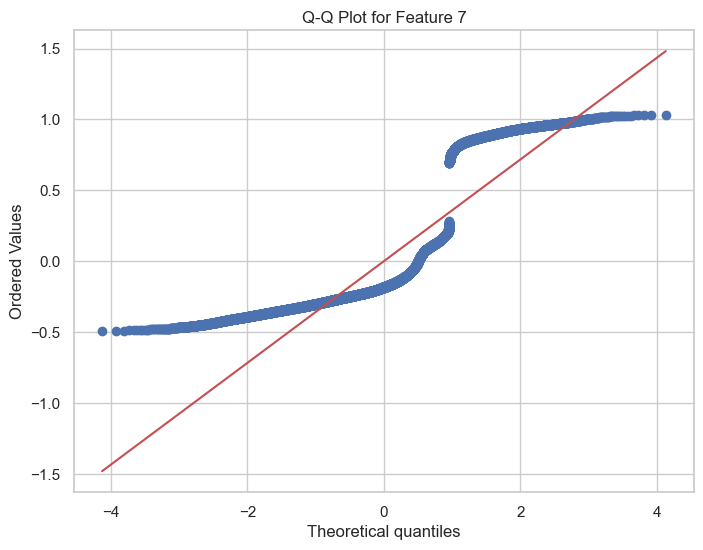

Shapiro-Wilk Test for Feature 7:
Statistic = 0.7449, p-value = 0.0000
The data for Feature 7 does not appear to be normally distributed (p <= 0.05).


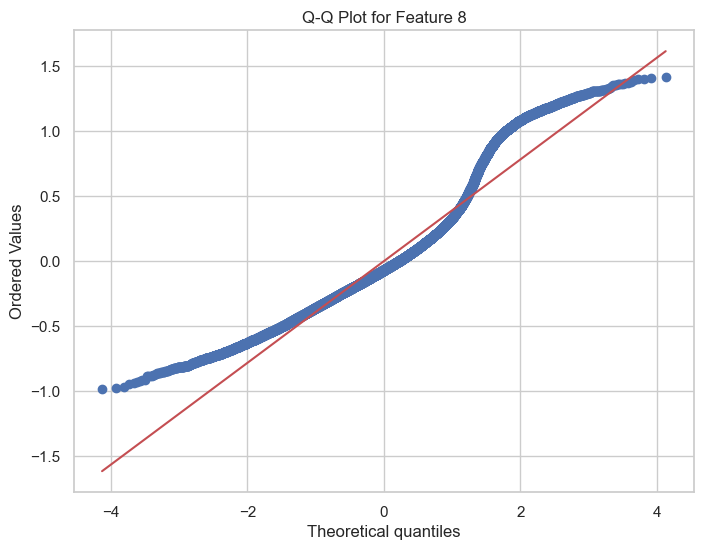

Shapiro-Wilk Test for Feature 8:
Statistic = 0.9325, p-value = 0.0000
The data for Feature 8 does not appear to be normally distributed (p <= 0.05).


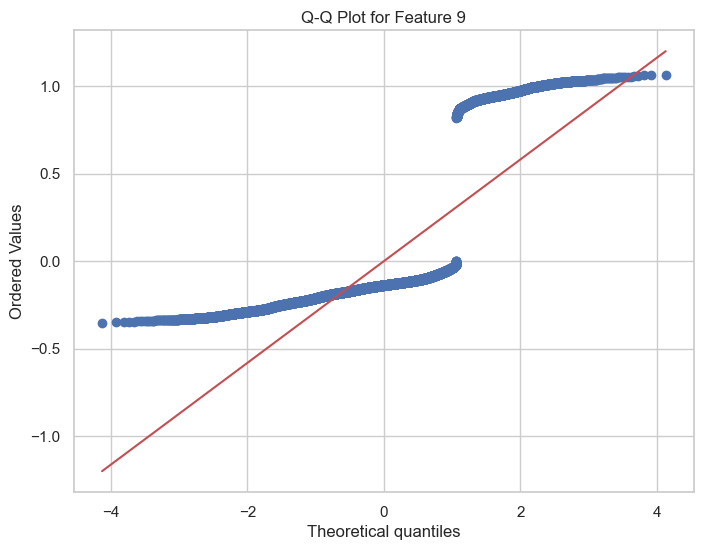

Shapiro-Wilk Test for Feature 9:
Statistic = 0.5677, p-value = 0.0000
The data for Feature 9 does not appear to be normally distributed (p <= 0.05).


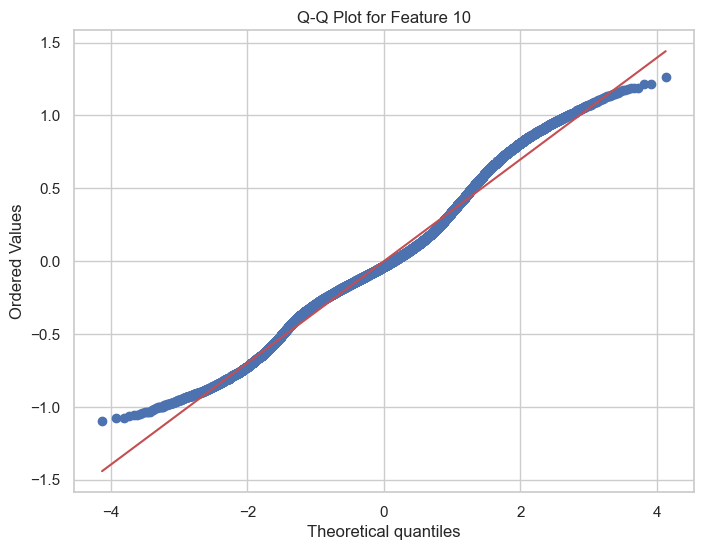

Shapiro-Wilk Test for Feature 10:
Statistic = 0.9816, p-value = 0.0000
The data for Feature 10 does not appear to be normally distributed (p <= 0.05).


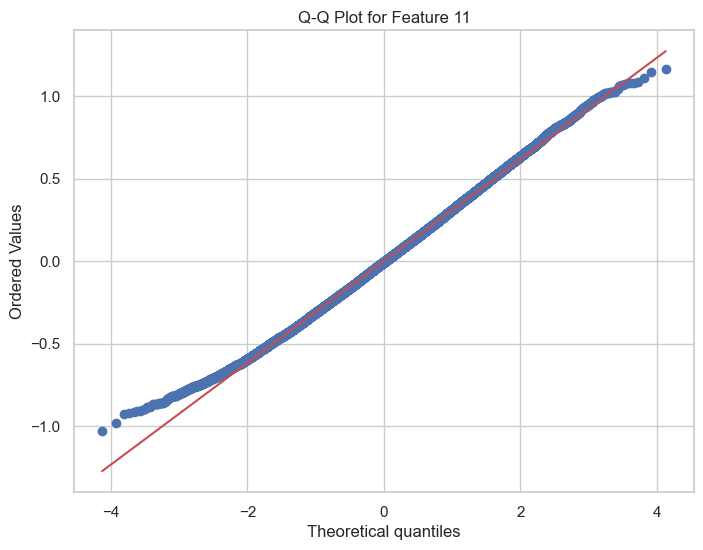

Shapiro-Wilk Test for Feature 11:
Statistic = 0.9984, p-value = 0.0000
The data for Feature 11 does not appear to be normally distributed (p <= 0.05).


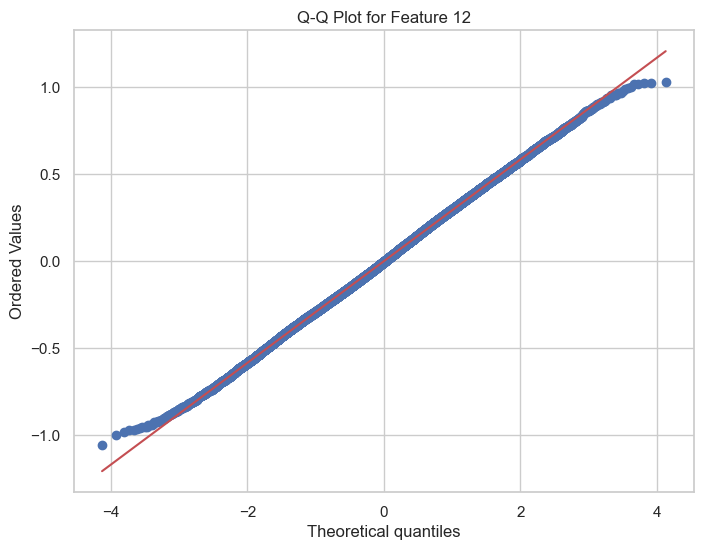

Shapiro-Wilk Test for Feature 12:
Statistic = 0.9997, p-value = 0.0000
The data for Feature 12 does not appear to be normally distributed (p <= 0.05).


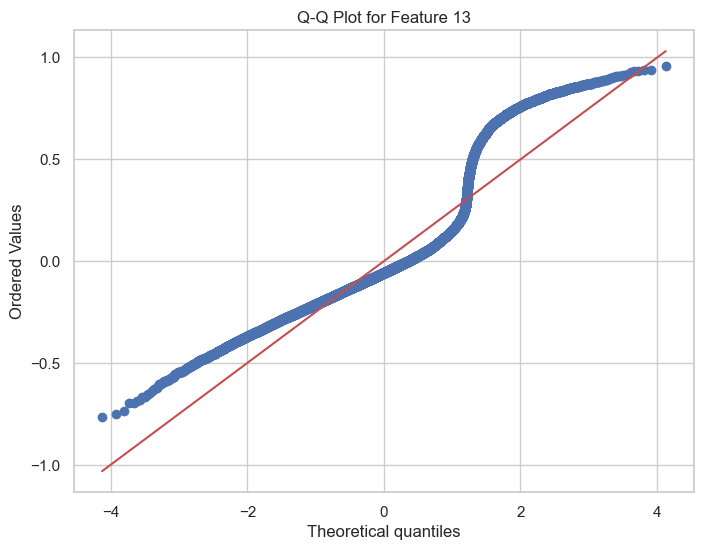

Shapiro-Wilk Test for Feature 13:
Statistic = 0.8504, p-value = 0.0000
The data for Feature 13 does not appear to be normally distributed (p <= 0.05).


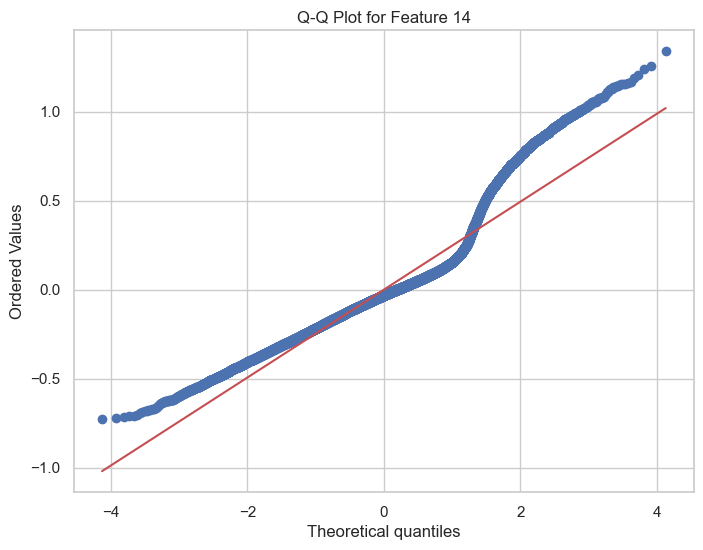

Shapiro-Wilk Test for Feature 14:
Statistic = 0.9019, p-value = 0.0000
The data for Feature 14 does not appear to be normally distributed (p <= 0.05).


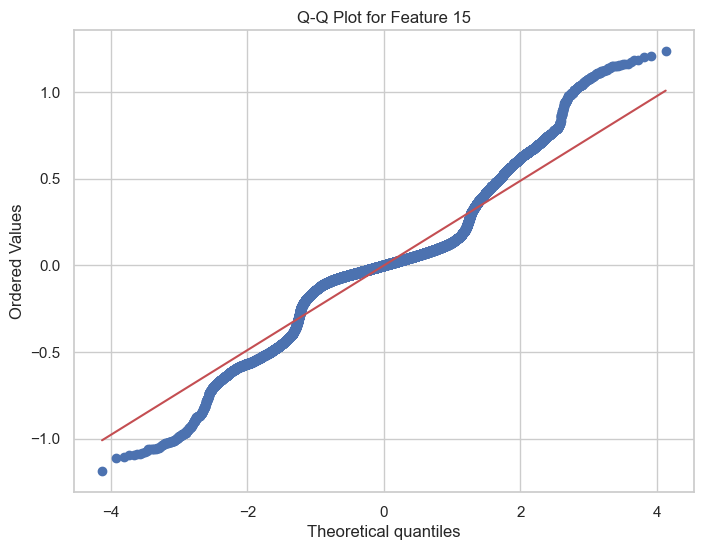

Shapiro-Wilk Test for Feature 15:
Statistic = 0.9078, p-value = 0.0000
The data for Feature 15 does not appear to be normally distributed (p <= 0.05).


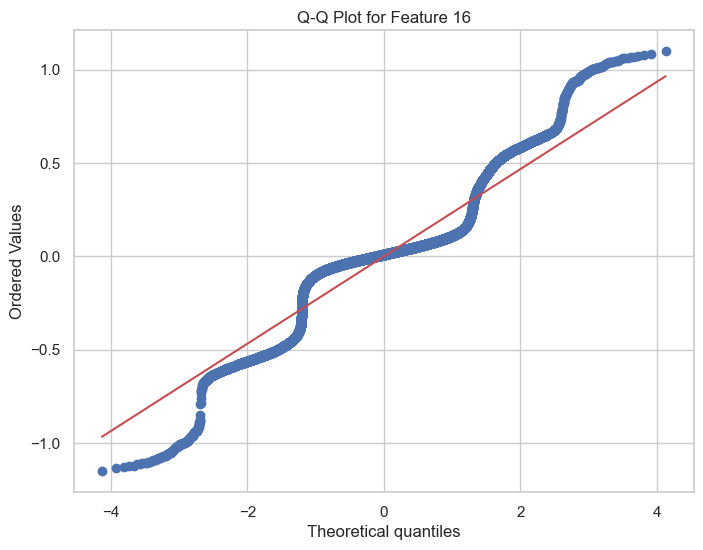

Shapiro-Wilk Test for Feature 16:
Statistic = 0.8644, p-value = 0.0000
The data for Feature 16 does not appear to be normally distributed (p <= 0.05).


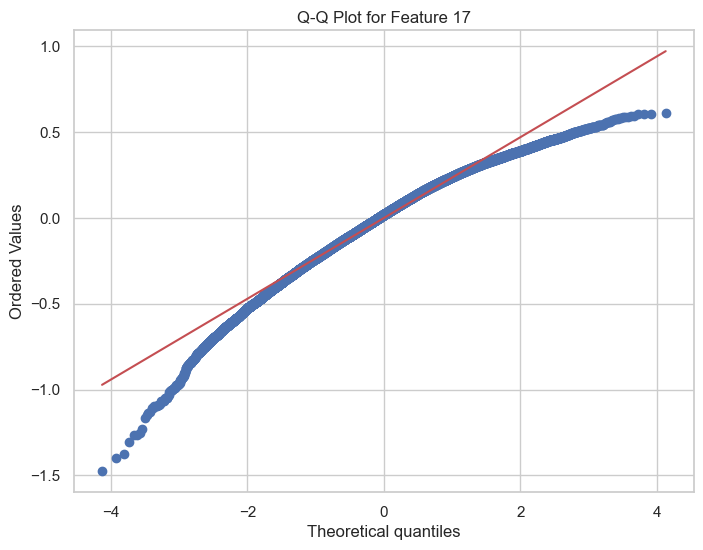

Shapiro-Wilk Test for Feature 17:
Statistic = 0.9803, p-value = 0.0000
The data for Feature 17 does not appear to be normally distributed (p <= 0.05).


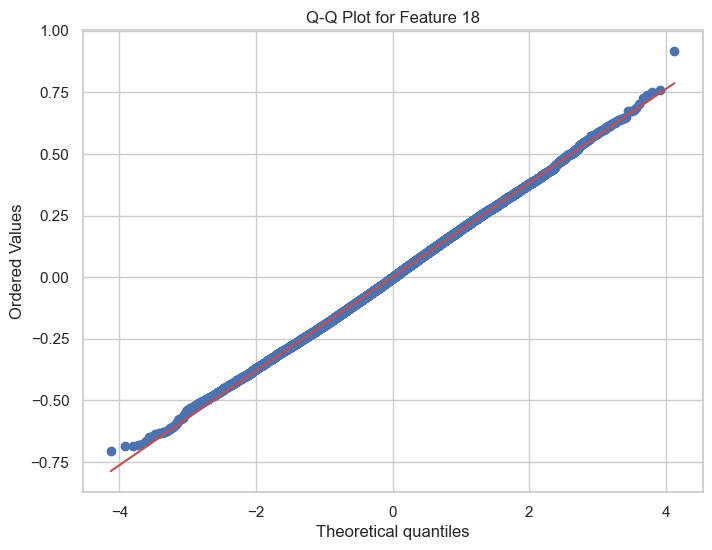

Shapiro-Wilk Test for Feature 18:
Statistic = 0.9995, p-value = 0.0000
The data for Feature 18 does not appear to be normally distributed (p <= 0.05).


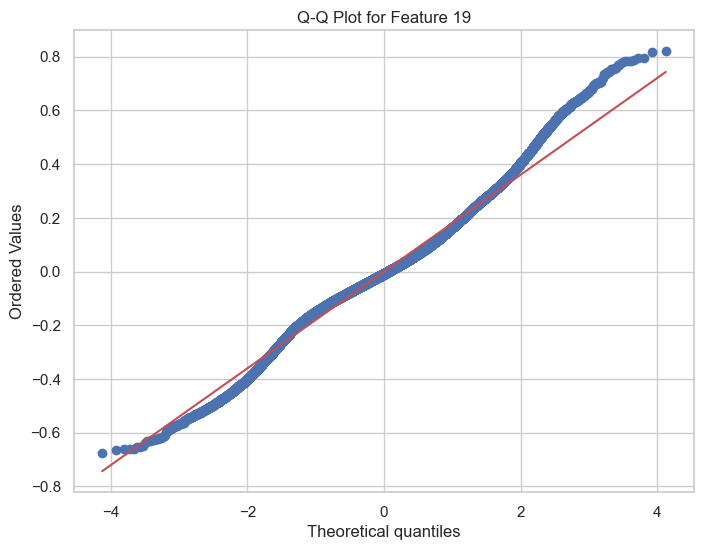

Shapiro-Wilk Test for Feature 19:
Statistic = 0.9826, p-value = 0.0000
The data for Feature 19 does not appear to be normally distributed (p <= 0.05).


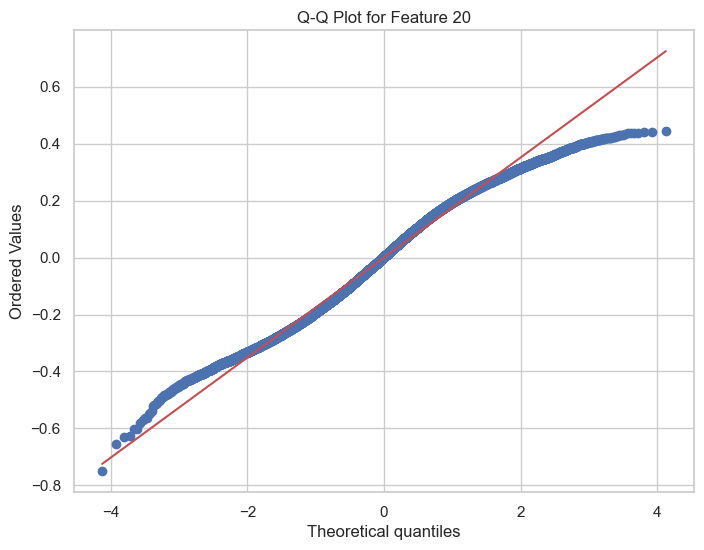

Shapiro-Wilk Test for Feature 20:
Statistic = 0.9878, p-value = 0.0000
The data for Feature 20 does not appear to be normally distributed (p <= 0.05).


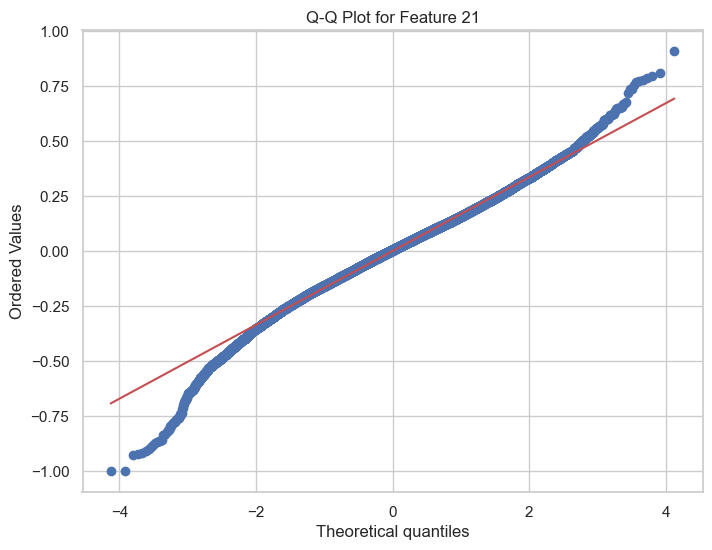

Shapiro-Wilk Test for Feature 21:
Statistic = 0.9923, p-value = 0.0000
The data for Feature 21 does not appear to be normally distributed (p <= 0.05).


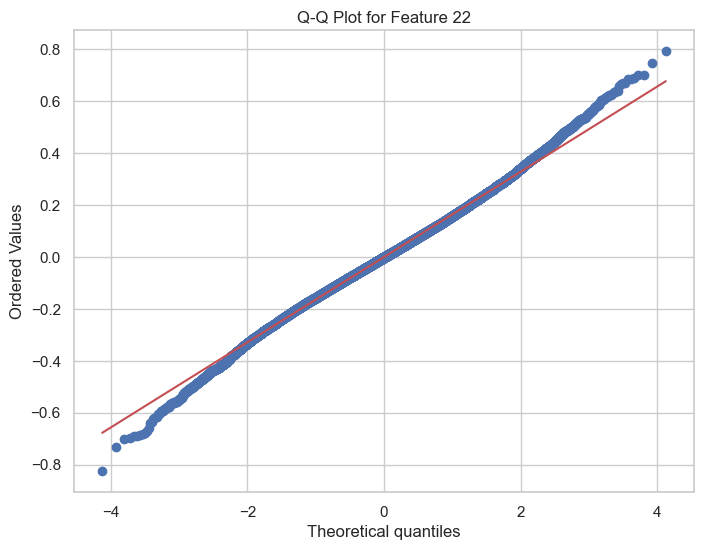

Shapiro-Wilk Test for Feature 22:
Statistic = 0.9974, p-value = 0.0000
The data for Feature 22 does not appear to be normally distributed (p <= 0.05).


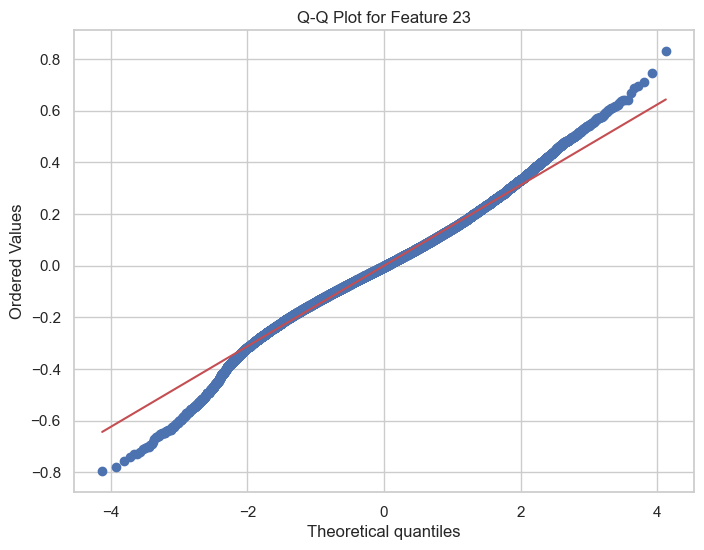

Shapiro-Wilk Test for Feature 23:
Statistic = 0.9901, p-value = 0.0000
The data for Feature 23 does not appear to be normally distributed (p <= 0.05).


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Assuming dataset_reduced_features is a 2D NumPy array
dataset_reduced_features = reduced_data.copy()

# Q-Q plot function
def plot_qq(data, feature_index):
    plt.figure(figsize=(8, 6))
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for Feature {feature_index}')
    plt.show()

# Shapiro-Wilk test function
def shapiro_test(data, feature_index):
    stat, p_value = stats.shapiro(data)
    print(f'Shapiro-Wilk Test for Feature {feature_index}:')
    print(f'Statistic = {stat:.4f}, p-value = {p_value:.4f}')
    if p_value > 0.05:
        print(f'The data for Feature {feature_index} appears to be normally distributed (p > 0.05).')
    else:
        print(f'The data for Feature {feature_index} does not appear to be normally distributed (p <= 0.05).')

# Loop through each column (feature) in the 2D NumPy array
for i in range(dataset_reduced_features.shape[1]):
    data = dataset_reduced_features[:, i]  # Extract the feature as a 1D array
    plot_qq(data, i)
    shapiro_test(data, i)


In [28]:
print(reduced_data)

[[-4.58353710e-01 -6.81198709e-01 -2.02367409e-01 ... -1.95193074e-01
   1.08972918e-01 -6.76402161e-02]
 [-3.79971116e-01  1.04603188e-02  1.30196039e+00 ...  7.40391786e-02
   1.66145925e-01  7.22221845e-02]
 [-5.18383641e-01  2.66782285e-01  7.85665827e-01 ... -1.37451223e-01
  -3.68526328e-01  3.62953784e-01]
 ...
 [-4.78687006e-02 -3.98924896e-01 -1.87729571e-01 ... -1.73942913e-01
   1.61384668e-01  1.36051559e-01]
 [ 1.31123192e+00  3.04805152e-01  1.58135734e-01 ...  7.06297143e-02
   1.79788804e-01 -3.81923879e-04]
 [-2.43942205e-01 -7.90181306e-01 -3.79313627e-01 ... -1.82888276e-01
  -6.12022623e-02 -7.37304312e-02]]


In [30]:
# Print the shape of the data to determine the number of data points and dimensions
print(f"Shape of reduced_data_selected: {reduced_data_selected[:, :3].shape}")


Shape of reduced_data_selected: (37963, 3)
